In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scanpy as sc
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize

In [2]:
logs = pd.read_csv("Simulated_200_entries.csv",index_col=0)

In [3]:
logs.shape

(200, 4)

In [4]:
logs

,patient_obj_id,employee,time,access_action_obj_id
0,Patient A,Provider A,2020-06-30 11:59:33.874630,Event type 0
1,Patient A,Provider A,2020-06-30 11:59:34.874630,Event type 1
2,Patient A,Provider A,2020-06-30 11:59:35.874630,Event type 2
3,Patient A,Provider A,2020-06-30 11:59:36.874630,Event type 1
4,Patient A,Provider A,2020-06-30 12:04:33.874630,Event type 3
...,...,...,...,...
195,Patient C,Provider F,2020-06-30 16:09:34.874630,Event type 7
196,Patient C,Provider F,2020-06-30 16:09:35.874630,Event type 7
197,Patient C,Provider F,2020-06-30 16:09:36.874630,Event type 7
198,Patient C,Provider F,2020-06-30 16:14:33.874630,Event type 7


In [5]:
logs.time = pd.to_datetime(logs.time)

In [6]:
unique_role = logs.employee.unique() 

In [7]:
def consecutive_diff_seconds(df_in):
    return(np.array([t - s for s, t in zip(df_in.time, df_in.time[1:])]).astype('timedelta64[s]').astype(int)) #not that slow, maybe generate for each user

In [8]:
unique_role

array(['Provider A', 'Provider B', 'Provider C', 'Provider D',
       'Provider E', 'Provider F'], dtype=object)

In [9]:
sessions_list = []
session_actions_list = []
consec_diff_list = []
for provider in unique_role:
    provider_subset = logs[logs.employee == provider]
    provider_patients = provider_subset.patient_obj_id.unique()
    print(provider)
    for patient in provider_patients:
        provider_patient_subset = provider_subset[provider_subset.patient_obj_id == patient].copy()
        provider_patient_subset = provider_patient_subset.sort_values(by='time',ascending=True).copy()
        provider_patient_subset_consec_diff = consecutive_diff_seconds(provider_patient_subset)
        #consec_diff_list.append(provider_patient_subset_consec_diff)
        cutoff_times = np.where(provider_patient_subset_consec_diff>120)[0] #2 minute cutoff, 1.25 hour cutoff now
        provider_patient_sessions = np.split(provider_patient_subset,cutoff_times+1)
        session_actions = np.split(provider_patient_subset.access_action_obj_id,cutoff_times+1)
        session_diff_times = np.split(provider_patient_subset_consec_diff,cutoff_times+1)
        consec_diff_list.append(session_diff_times)
        sessions_list.append(provider_patient_sessions)
        session_actions_list.append(session_actions)

Provider A
Provider B
Provider C
Provider D
Provider E
Provider F


In [10]:
concat_sessions_list = []
for prov_pat in sessions_list:
    for sessions in prov_pat:
        concat_sessions_list.append(sessions)

In [11]:
concatenated_actions = []
for prov_pat in session_actions_list:
    for sessions in prov_pat:
        concatenated_actions.append(sessions)

In [12]:
concatenated_differences = []
for prov_pat in concat_sessions_list:
    concatenated_differences.append(consecutive_diff_seconds(prov_pat))

In [13]:
concatenated_sessions_drop_last = []
for prov_pat in concat_sessions_list:
    concatenated_sessions_drop_last.append(prov_pat.head(len(prov_pat)-1))

In [14]:
for i in range(len(concatenated_sessions_drop_last)):
    if(i%10==0):
        print(int(i/len(concatenated_sessions_drop_last)*100))
    concatenated_sessions_drop_last[i]['ELAPSED[s]'] = concatenated_differences[i].copy()

0
19
38
57
76
96


/home/bob/anaconda3/envs/hci/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
concatenated_differences_array = np.concatenate(concatenated_differences)

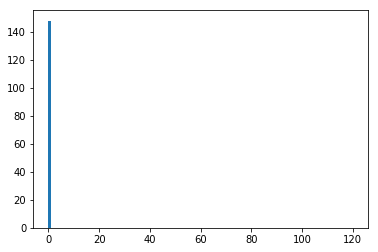

In [16]:
hist_out = plt.hist(concatenated_differences_array,bins=100,range=(0,120),log=False)

In [17]:
np.where(concatenated_differences_array<120)[0].shape[0]/concatenated_differences_array.shape[0]

1.0

In [18]:
session_counts = pd.DataFrame(np.zeros([len(concatenated_actions),len(logs.access_action_obj_id.unique())],dtype='int'))
session_counts.columns = logs.access_action_obj_id.unique()

In [19]:
for i in range(len(concatenated_actions)):
    session_counts.iloc[i] = concatenated_actions[i].value_counts() 
session_counts = session_counts.fillna(value=0)

In [20]:
meta_session_list = []
meta_start_time_list = []
meta_end_time_list = []
meta_emp_list = []
meta_pat_list = []
for prov_pat in sessions_list:
    for sessions in prov_pat:
        meta_emp_list.append(sessions.employee.head(1))
        meta_pat_list.append(sessions.patient_obj_id.head(1))
        meta_start_time_list.append(sessions.time.head(1))
        meta_end_time_list.append(sessions.time.tail(1))
        meta_session_list.append(sessions)

In [21]:
meta_session_array = np.concatenate(meta_session_list)
meta_start_time_array = np.concatenate(meta_start_time_list)
meta_end_time_array = np.concatenate(meta_end_time_list)
meta_pat_array = np.concatenate(meta_pat_list)
meta_emp_array = np.concatenate(meta_emp_list)

In [22]:
meta_table = pd.DataFrame(np.zeros([len(meta_session_list),4]))

In [23]:
meta_table.columns=['patient_obj_id','employee','start_time','end_time']

In [24]:
meta_table['start_time'] = meta_start_time_array
meta_table['end_time'] = meta_end_time_array
meta_table['patient_obj_id'] = meta_pat_array#np.arange(0,len(start_time_array))
meta_table['employee'] = meta_emp_array

In [25]:
meta_table.head()

,patient_obj_id,employee,start_time,end_time
0,Patient A,Provider A,2020-06-30 11:59:33.874630,2020-06-30 11:59:36.874630
1,Patient A,Provider A,2020-06-30 12:04:33.874630,2020-06-30 12:04:40.874630
2,Patient A,Provider A,2020-06-30 12:09:33.874630,2020-06-30 12:09:35.874630
3,Patient A,Provider A,2020-06-30 12:14:33.874630,2020-06-30 12:14:40.874630
4,Patient A,Provider A,2020-06-30 12:19:33.874630,2020-06-30 12:19:38.874630


In [26]:
session_counts.head()

,Event type 0,Event type 1,Event type 2,Event type 3,Event type 4,Event type 5,Event type 6,Event type 7,Event type 8,Event type 9,Event type 10,Event type 11,Event type 12,Event type 13,Event type 14,Event type 15,Event type 16,Event type 17
0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
session_counts.shape

(52, 18)

In [28]:
meta_table.shape

(52, 4)

In [29]:
#session_counts

In [30]:
session_counts.to_csv("Simulated_Session_Count_Matrix.csv")

In [31]:
meta_table.to_csv("Simulated_Session_Metadata.csv")